In [12]:
import sys
sys.path.append('./pyradi')

import pyradi.ryptw as ptw
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import cv2 as cv
import pandas as pd
from openpyxl import load_workbook
from tqdm import tqdm

# Initialization

In [13]:
def plank_func(t, *p):
    a, b, c, d, e = p
    return a*t**4 + b*t**3 + c*t**2 + d*t**1 + e

In [14]:
def DLtoT_func(dl,*p):
    a,b,c,d,e = p
    return a*dl**0.25 + b*dl**0.5 + c*dl + d*dl**0.3 + e

In [15]:
def Calibration(DL,T):
    popt, pcov = curve_fit(plank_func, DL, T, p0 = [1,0,0,0,0])
    return popt

In [16]:
def find_heater_area(arr):
    
    arr = np.array(arr/arr.max()*255, dtype = np.uint8)
    blurred = cv.GaussianBlur(arr, (5, 5), 0)
    ret, threshold = cv.threshold(blurred, 0.85*arr.max(), arr.max(), cv.THRESH_BINARY_INV)
    threshold = threshold.astype(np.uint8)

    contours, hierarchy = cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    rect = cv.minAreaRect(contours[-1]) # пытаемся вписать прямоугольник
    box = cv.boxPoints(rect)
    box = np.int0(box)

    #cv.drawContours(image = threshold, contours = [box], contourIdx = 0, color = (255,255,255), thickness = 2)
    #cv.namedWindow('Display', cv.WINDOW_NORMAL)
    #cv.imshow('Display', threshold)

    #cv.waitKey()
    #cv.destroyAllWindows()
    
    x0, y0 = box[1]
    x1, y1 = box[3]
    
    fig, ax = plt.subplots(1,1, figsize=(6, 4))
    ax.matshow(threshold, cmap='Reds')
    rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    
    return x0, y0, x1, y1

In [17]:
def film_processing (filename, func):
    #x0, y0, x1, y1 = area_coordinates
    
    h = ptw.readPTWHeader(filename)
    N = h.h_NumberOfFieldInFile
    #frame_index = list(range(1,N))
    #frames = ptw.getPTWFrames(h, frame_index)[0]
    #heater_areas = frames[:,x0:x1,y0:y1]
    #average_DL = np.average(heater_areas, axis=(1,2))

    average_DL = np.zeros(N)
    max_DL = np.zeros(N)
    for i in range(1,N//4):
        frame = ptw.getPTWFrame(h, i)[0]
        heater_area = frame[x0:x1,y0:y1]
        average_DL[i-1] = np.average(heater_area)
        max_DL[i-1] = np.max(heater_area)
    
    area_av_T = func(average_DL[average_DL!=0], *calib_param)
    area_max_T = func(max_DL[max_DL!=0], *calib_param)
    
    return np.average(area_av_T), np.average(area_max_T)

In [18]:
def data_representation (filename, av_results, max_results):
    
    df = pd.read_excel(filename)
    T_column_list = np.where(df == "Tito")[1]

    wb = load_workbook(filename)
    sheet = wb['Кривые теплообмена']  
    
    n = len(av_results)
    i = 0
    for col in T_column_list:
        n_row_in_col = len([x for x in df[df.columns[col-1]][2:] if not np.isnan(x)])
        for row in range(n_row_in_col):
            sheet.cell(column = col+1, row = 4+row).value = av_results[i]
            sheet.cell(column = col+2, row = 4+row).value = max_results[i]
            i += 1
            if i>= n:
                wb.save(filename)
                return
                
    wb.save(filename)
    return

# Calibration

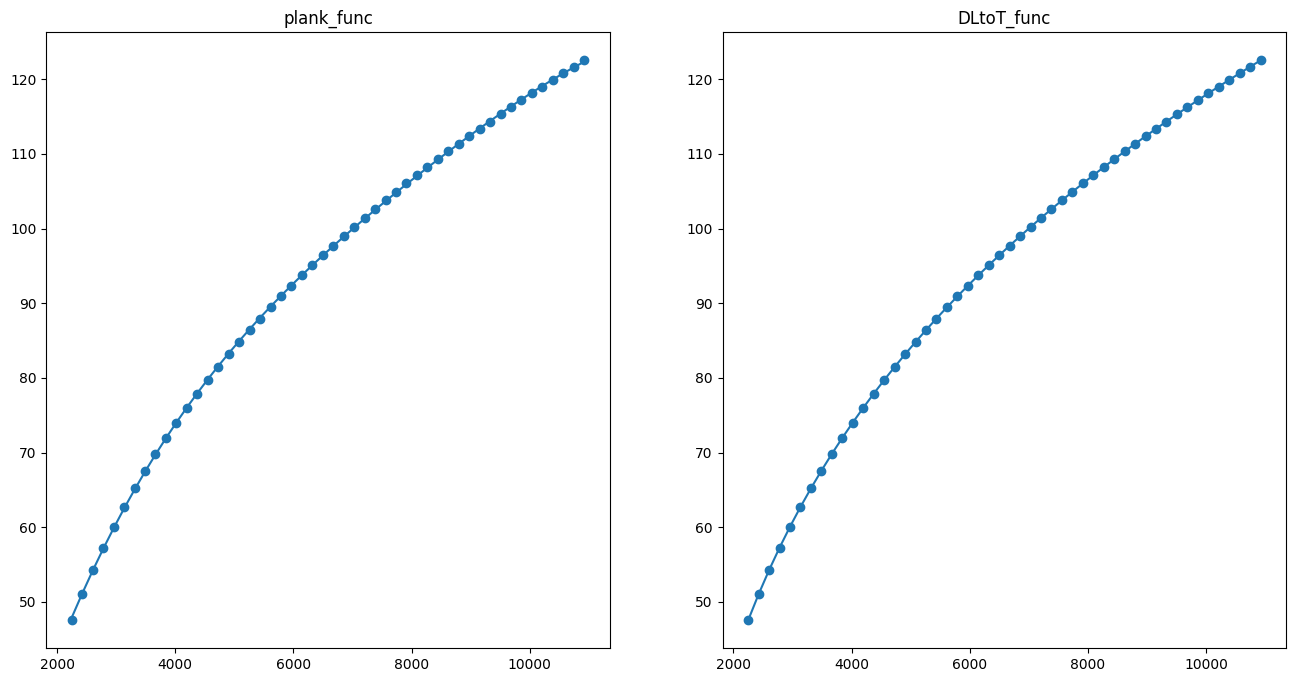

In [19]:
# DA nozzle!
# date = input("Enter calibration date (yy-mm-dd): ")
DL, T = np.loadtxt(f"./23-04-11.txt", comments =  '#', unpack = True)

calib_param_1, pcov = curve_fit(plank_func, DL, T, p0 = [1,0,0,0,0])
calib_param_2, pcov = curve_fit(DLtoT_func, DL, T, p0 = [1,0,0,0,0])

fig, axs = plt.subplots(1,2, figsize=(16, 8))
axs[0].scatter(DL,T)
axs[0].plot(DL, plank_func(DL, *calib_param_1))
axs[0].set_title("plank_func")

axs[1].scatter(DL,T)
axs[1].plot(DL, DLtoT_func(DL, *calib_param_2))
axs[1].set_title("DLtoT_func")

plt.show()

In [20]:
calib_param = calib_param_2
dl2tFunction = DLtoT_func
print(f"\nCalibration parameters: {calib_param}")
# calib_flag = f"RSF from {date}"


Calibration parameters: [ 1.39262997e+03  2.57277133e+01 -1.27480487e-02 -9.65073036e+02
 -9.58288511e+02]


In [21]:
DLtoT_func(4400, *calib_param)

78.16794313057937

# Search heater area

C:\Users\Covald\AppData\Local\Temp\ipykernel_13444\2564538821.py:11: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


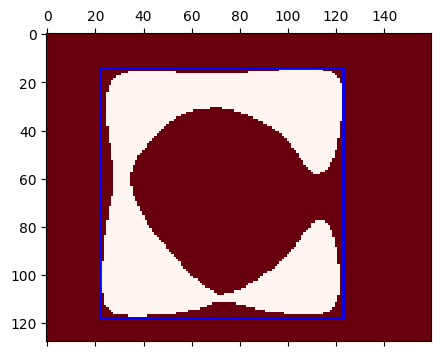

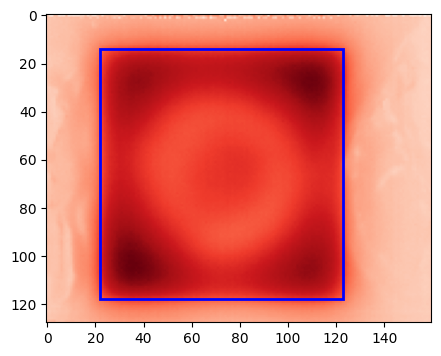

22 14 123 118


In [55]:
folderpass = 'C:\\Курсач\\данные\\11.04.23\\'
index = int(input("Enter good Cap: "))

filename = f"{folderpass}/Cap-{index:06}.ptw"
h = ptw.readPTWHeader(filename)
frame = ptw.getPTWFrame(h, 1)[0]
x0, y0, x1, y1 = find_heater_area(frame)

fig, ax1 = plt.subplots(1,1, figsize=(12, 4))
rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')

ax1.imshow(frame, cmap='Reds')
ax1.add_patch(rect)

#ax2.matshow(threshold, cmap='Reds')
#ax2.add_patch(rect)

plt.show()

print(x0, y0, x1, y1)

#flag = int(input("Is countour ok? Enter 0 if yes, 1 else: "))
#if flag != 0:
#    input_list = input("Enter manually new area boundary separated by commas: ")
#    x0, y0, x1, y1 = [int(v) for v in input_list.split(",")]

In [ ]:
x0, y0, x1, y1 = 22, 14, 123, 118
fig, ax1 = plt.subplots(1,1, figsize=(12, 4))
rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')

rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')
ax1.imshow(frame, cmap='Reds')
ax1.add_patch(rect)

plt.show()

In [51]:
def rotation(img, angle):
    (h, w) = img.shape[:2]
    center = (int(w / 2), int(h / 2))
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1)
    #return rotation_matrix 
    rotated = cv.warpAffine(img, rotation_matrix, (w, h))
    return rotated

Enter good Cap: 129


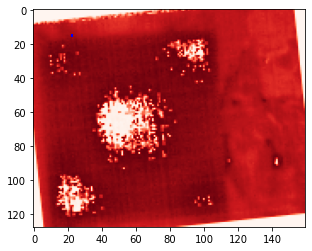

In [72]:
index = int(input("Enter good Cap: "))
filename = f"D:/Surtaev Team/2023 February/23-02-21/Cap-{index:06}.ptw"
h = ptw.readPTWHeader(filename)
frame = ptw.getPTWFrame(h, 1)[0]

arr = np.array(frame, dtype = np.uint8)
arr = rotation(arr, 6)

fig, ax1 = plt.subplots(1,1, figsize=(12, 4))
rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')
ax1.imshow(arr, cmap='Reds')
ax1.add_patch(rect)

plt.show()

In [48]:
index = int(input("Enter good Cap: "))
filename = f"D:/Surtaev Team/2023 February/23-02-21/Cap-{index:06}.ptw"
h = ptw.readPTWHeader(filename)
frame = ptw.getPTWFrame(h, 1)[0]

arr = np.array(frame, dtype = np.uint8)
#arr = cv.cvtColor( frame, cv.COLOR_BGR2HSV ) 
blurred = cv.GaussianBlur(arr, (5, 5), 0)
#ret, threshold = cv.threshold(blurred, 0.85*arr.max(), arr.max(), cv.THRESH_BINARY_INV)

hsv_min = np.array(180, np.uint8)
hsv_max = np.array(225, np.uint8)
threshold = cv.inRange( blurred, hsv_min, hsv_max )
threshold = threshold.astype(np.uint8)

contours, hierarchy = cv.findContours( threshold.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    rect = cv.minAreaRect(cnt) # пытаемся вписать прямоугольник
    box = cv.boxPoints(rect) # поиск четырех вершин прямоугольника
    box = np.int0(box) # округление координат
    cv.drawContours(blurred,[box],0,(255,0,0),2)

x0, y0 = box[1]
x1, y1 = box[3]

#fig, ax1 = plt.subplots(1,1, figsize=(12, 4))
#ax1.imshow(frame, cmap='Reds')
#rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')
#ax1.add_patch(rect)
#plt.show()

cv.imshow('contours', arr) # вывод обработанного кадра в окно
cv.waitKey()
cv.destroyAllWindows()

Enter good Cap: 129


In [26]:
blurred.min()

7

# Average temperature retreiving

In [61]:
# file pass for DA nozzle!

print(f"You're using calibration for {calib_flag} \n")

cap_list = []
experiment_date = input("Enter xlsx filename: ")
df = pd.read_excel(f"C:/Курсач/данные/софт/{experiment_date}.xlsx")
cap_column_list = np.where(df == "Cap")[1]
for col in cap_column_list:
    cap_list.append([x for x in df[df.columns[col]][2:] if not np.isnan(x)])
cap_list = sum(cap_list, [])

average_T_list = []
max_T_list = []
std_T_list = []
folderpass = input("Enter a right file pass of experimental data!\n")
for i in tqdm(cap_list):
    if i>= 164:
        x0, y0, x1, y1 = 17,20,110,115
    else:
        x0, y0, x1, y1 = 17, 20, 110, 110
        
    filename = f"{folderpass}/Cap-{i:06}.ptw"
    average_T, max_T = film_processing(filename, dl2tFunction)
    average_T_list.append(average_T) 
    max_T_list.append(max_T)
    res = np.column_stack([np.array(cap_list[:len(average_T_list)]).transpose(),\
                           np.array(average_T_list).transpose(), np.array(max_T_list).transpose()])
    np.savetxt(fname = f'C:/Курсач/данные/11.04.23/{experiment_date}.txt',\
               header = 'Cap No.   average T     max T', X = res, fmt="%s")

cap_data, av_T_data, max_T_data = np.loadtxt(f'C:/Курсач/данные/11.04.23/{experiment_date}.txt',\
                              comments = '#', unpack = True)
data_representation(f"C:/Курсач/данные/11.04.23/{experiment_date}.xlsx", av_T_data, max_T_data)
print("SUCCESS!")

You're using calibration for RSF from  



100%|██████████| 208/208 [25:42<00:00,  7.41s/it]


SUCCESS!


In [103]:
cap_data, av_T_data, max_T_data = np.loadtxt(f'C:/Users/GreatWorker/Work/Spray/DA/python data/23-02-21.txt',\
                              comments = '#', unpack = True)
data_representation(f"C:/Users/GreatWorker/Work/Spray/DA/{experiment_date}.xlsx", av_T_data, max_T_data)  

In [43]:
cap_list = []
experiment_date = input("Enter xlsx filename: ")
df = pd.read_excel(f"C:/Users/GreatWorker/Work/Spray/DA/{experiment_date}.xlsx")
cap_column_list = np.where(df == "Cap")[1]
for col in cap_column_list:
    cap_list.append([x for x in df[df.columns[col]][2:] if not np.isnan(x)])
cap_list = sum(cap_list, [])

Enter xlsx filename: 23-02-21


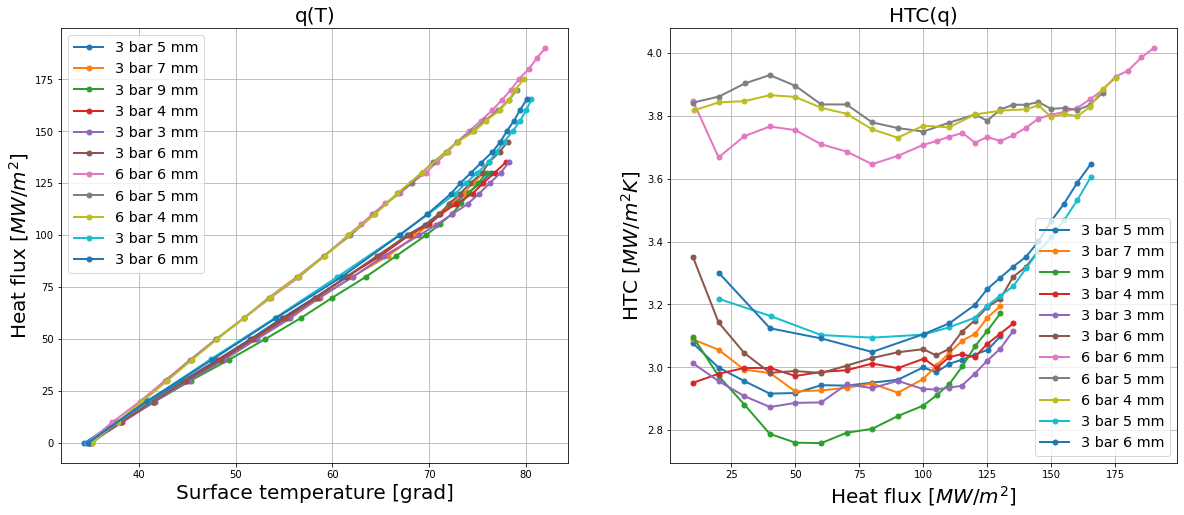

In [13]:
# здесь хочу сделать построение графиков q(T av), HTC(q)
filename = f'C:/Users/GreatWorker/Work/Spray/Huawei/{experiment_date} results.xlsx'
df = pd.read_excel(filename)

T_column_list = np.where(df == "Tito")[1]
label_list = np.where(df == "label")[1]

n = len(T_column_list)
q = []
T = []
label = []

for col in T_column_list:
    q.append([x for x in df[df.columns[col-1]][2:] if not np.isnan(x)])
    T.append([x for x in df[df.columns[col+1]][2:] if not np.isnan(x)])

for i in range(len(label_list)):
    label.append(df[df.columns[label_list[i]]][10])

dT = [np.array(x)-x[0] for x in T]
HTC = []
for i in range(len(dT)):
    HTC.append(np.array(q[i][1:])/np.array(dT[i][1:]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 8))
plt.rcParams.update({'font.size': 12})
for i in range(n):
    ax1.plot(T[i], q[i], label = label[i], marker = '.', markersize = 10, linewidth = 2)
    ax2.plot(q[i][1:], HTC[i], label = label[i], marker = '.', markersize = 10, linewidth = 2)

ax1.legend(loc = 'best', fontsize = 'large')    
ax1.grid()   
ax1.set_title('q(T)', fontsize = 20)
ax1.set_xlabel(r'Surface temperature [grad]', fontsize = 20)
ax1.set_ylabel(r'Heat flux [$MW/m^2$]', fontsize = 20)

ax2.legend(loc = 'best', fontsize = 'large')    
ax2.grid() 
ax2.set_title('HTC(q)', fontsize = 20)
ax2.set_ylabel(r'HTC [$MW/m^2K$]', fontsize = 20)
ax2.set_xlabel(r'Heat flux [$MW/m^2$]', fontsize = 20)

plt.show()     

# Junk

In [ ]:
N = h.h_NumberOfFieldInFile
frame_DL = np.zeros(N)
for i in range(1,N):
    frame = ptw.getPTWFrame(h, i)[0]
    heater_area = frame[x0:x1,y0:y1]
    frame_DL[i-1] = np.average(heater_area)
    
    
    
    #fig, ax = plt.subplots()
    #ax.matshow(heater_area, cmap='Reds')
    #plt.show()
    
average_DL = np.average(frame_DL[frame_DL!=0])
T = plank_func(average_DL, *calib_param)
print(T)

In [32]:
h = ptw.readPTWHeader("Cap-000010.ptw")
arr = ptw.getPTWFrame(h, 1)[0]

arr = np.array(arr/arr.max()*255, dtype = np.uint8)
blurred = cv.GaussianBlur(arr, (5, 5), 0)
ret, threshold = cv.threshold(blurred, 0.85*arr.max(), arr.max(), cv.THRESH_BINARY_INV)
threshold = threshold.astype(np.uint8)

contours, hierarchy = cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
rect = cv.minAreaRect(contours[-1]) # пытаемся вписать прямоугольник
box = cv.boxPoints(rect)
box = np.int0(box)

cv.drawContours(image = threshold, contours = [box], contourIdx = 0, color = (255,255,255), thickness = 2)
cv.namedWindow('Display', cv.WINDOW_NORMAL)
cv.imshow('Display', threshold)

cv.waitKey()
cv.destroyAllWindows()

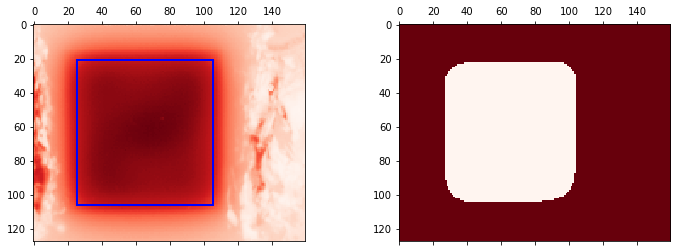

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
x0, y0, x1, y1 = find_heater_area("Cap-000010.ptw")
rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='b', facecolor='none')

ax1.matshow(arr, cmap='Reds')
ax1.add_patch(rect)

ax2.matshow(threshold, cmap='Reds')
#ax2.add_patch(rect)

plt.show()

In [159]:
%%time 

h = ptw.readPTWHeader("Cap-000010.ptw")
N = h.h_NumberOfFieldInFile
#frame_index = list(range(1,N))
#frames = ptw.getPTWFrames(h, frame_index)[0]
#heater_areas = frames[:,x0:x1,y0:y1]
#average_DL = np.average(heater_areas, axis=(1,2))

average_DL = np.zeros(N)
for i in range(1,N//3):
    frame = ptw.getPTWFrame(h, i)[0]
    heater_area = frame[x0:x1,y0:y1]
    average_DL[i-1] = np.average(heater_area)
T = plank_func(average_DL[average_DL!=0], *calib_param)

print(np.average(T), np.std(T))

82.00025282540759 0.1318322220587366
Wall time: 16.3 s


In [151]:
%%time

frame_index = list(range(1,501))
frames = ptw.getPTWFrames(h, frame_index)[0]

Wall time: 13.6 s


In [153]:
%%time

for i in range(1,1001):
    frame = ptw.getPTWFrame(h, i)[0]

Wall time: 10.9 s


In [83]:
a = np.array([1,2,3,4,5,6,7,8,9])

In [85]:
a[5:3]

array([], dtype=int32)

In [284]:
df = pd.read_excel('22-12-26 results.xlsx')
T_column_list = np.where(df == "Tito")[1]

wb = load_workbook('22-12-26 results.xlsx')
sheet = wb.active   

for col in T_column_list:
    n_row_in_col = len([x for x in df[df.columns[col-1]][2:] if not np.isnan(x)])
    for row in range(n_row_in_col):
        sheet.cell(column = col+1, row = 4+row).value = 3

wb.save('22-12-26 results.xlsx')

In [162]:
df = pd.read_excel('22-12-26 results.xlsx')
res = []
for col in T_column_list:
    res.append([x for x in df[df.columns[col-1]][2:] if not np.isnan(x)])


IndexError: index 47 is out of bounds for axis 0 with size 43